In [1]:
import pandas as pd
import os
import torch 
import torch.nn as nn
import torchvision
import codecs
from collections import Counter,defaultdict
from nltk.corpus import stopwords
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string

In [2]:
#raw_dataframe = pd.read_csv("../data/Labelled_tweets_v1.csv",header = None)
tweets = []
data_pd = pd.read_csv("../data/Labelled_tweets_v1.csv")
#print(data_pd.head(10))
data_tweet = data_pd['Tweet']
for i in data_tweet:
  j = i.split()
  for k in j:
    tweets.append(k)

In [4]:
issues_pd = data_pd['Issue']
stance_pd = data_pd['Stance']

all_words = tweets
word2cnt = Counter(all_words)
stop_words = stopwords.words('english')

In [5]:
with codecs.open('vocab_real.csv', 'w', 'utf-8') as fout:
  fout.write("{}{}1000000000\n{}{}1000000000\n{}{}1000000000\n{}{}1000000000\n".format("<PAD>",",", "<UNK>",",", "<S>",",", "</S>",","))
  for word, cnt in word2cnt.most_common(len(word2cnt)):
    if(word not in stop_words):
      fout.write("{}{}{} \n".format(word,',',cnt))

In [6]:
issues = []
for iss in issues_pd:
  if iss not in issues:
    issues.append(iss)
    
print(issues)

word_counts = pd.read_csv("vocab_real.csv",header=None)
data_list = data_pd.values
print(data_list[0:5])

['GST', 'PNB Scam', 'FDIPolicy', 'Padmavati film screening', 'Cauvery SC Verdict', 'Jallikattu ban', 'GDP growth', 'RightToPrivacy SC Verdict', 'Demonetisation', 'Swacch Bharat', 'Aadhar linking', 'Triple Talaq SC verdict', 'TripleTalaqBill', 'lgp price hike', 'reservation', 'Beef Ban', 'Inflation control', 'nsc and ppf rate cuts', 'Ram Mandir', 'EVM tampering', 'Fodder scam', 'hike in oil prices', 'Rohingyas', 'acchedin']
[['a no of people approach me daily worried abt the safety of their money in banks considering large no of bank frauds coming to light daily pm may kindly inform the public which bank is safe for people to keep their money URL sir there is a big rumour people are very skeptical that their saved money in the banks can go for a toss anytime hope wish pray that you our people all of us save the hard earned money in banks improve our incomes strengthen the income tax system'
  'ArvindKejriwal' 'AAP' 'GST' 'Disagreement']
 ['its now revealed that our fms silence on the pn

In [39]:
data_tweet = data_tweet.values.tolist()
for i in range(0,len(data_tweet)):
    data_tweet[i] = data_tweet[i].split()
    
print(data_tweet[0:5])

[['a', 'no', 'of', 'people', 'approach', 'me', 'daily', 'worried', 'abt', 'the', 'safety', 'of', 'their', 'money', 'in', 'banks', 'considering', 'large', 'no', 'of', 'bank', 'frauds', 'coming', 'to', 'light', 'daily', 'pm', 'may', 'kindly', 'inform', 'the', 'public', 'which', 'bank', 'is', 'safe', 'for', 'people', 'to', 'keep', 'their', 'money', 'URL', 'sir', 'there', 'is', 'a', 'big', 'rumour', 'people', 'are', 'very', 'skeptical', 'that', 'their', 'saved', 'money', 'in', 'the', 'banks', 'can', 'go', 'for', 'a', 'toss', 'anytime', 'hope', 'wish', 'pray', 'that', 'you', 'our', 'people', 'all', 'of', 'us', 'save', 'the', 'hard', 'earned', 'money', 'in', 'banks', 'improve', 'our', 'incomes', 'strengthen', 'the', 'income', 'tax', 'system'], ['its', 'now', 'revealed', 'that', 'our', 'fms', 'silence', 'on', 'the', 'pnb', 'scam', 'was', 'to', 'protect', 'his', 'lawyer', 'daughter', 'who', 'was', 'paid', 'a', 'large', 'retainer', 'by', 'the', 'accused', 'just', 'a', 'month', 'before', 'the', 

In [71]:
max_tweet_size = 0
for i in data_tweet:
    if(len(i)>max_tweet_size):
        max_tweet_size = len(i)

In [72]:
max_tweet_size

120

In [40]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said','a','URL','USER_MENTION']
tweets_after_stop_words=[]
for i in data_tweet:
    tweet = []
    for j in i:
        if(j not in stopset):
            tweet.append(j)
    tweets_after_stop_words.append(tweet)

In [51]:
model_wv = Word2Vec(data_tweet,min_count=0,window=5,size=100)
#len(word_counts)

In [42]:
tweet_vectors =[]
for i in range(0,len(tweets_after_stop_words)):
    tweet_vectors.append(model_wv[tweets_after_stop_words[i]])

/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# tweets_after_stop_words[0:5]

In [3]:
class Net(nn.Module):
    def __init__(self,vocab_size, hidden_size,input_size):
        super(Net,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.word_embeddings = nn.Embedding(vocab_size+106,100)
        self.GRU = nn.GRU(100,self.hidden_size,num_layers = 1, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, 3)
        self.softmax = nn.Softmax(dim=1)
        
        self.linear_label = nn.Linear(self.input_size, hidden_size)
        self.out_label = nn.Linear(self.hidden_size,self.output_size_label)
    
    def forward(self,x_input,hidden_state):
        embedded = self.word_embeddings(x_input)
        #print(embedded.shape)
        #output = embedded.view(-1,-1, self.hidden_size)
        output, hn = self.GRU(embedded)
        #hn_ = hn[0].reshape(x_input.shape[0],output.shape[1]*output.shape[2])
        #print(output.shape)
        #linear = self.linear(hn)
        #print(linear.shape)
        output_1 = self.linear_issue(hn)
        output_1 = F.relu(output_1)
        output_1 = self.out_issue(output_1)
        output_1 = self.softmax(output_1)
        
        return class_labels

    def H_t0(self, batch_size):
        return torch.zeros(1,batch_size,self.hidden_size)

In [45]:
def issue_vocab(issues,want = 'issue2id'):
    if(want == 'issue2id'):
        issue2idx = {issue:idx for idx,issue in enumerate(issues)}
        return issue2idx
    
    else:
        idx2issue = {idx:issue for idx,issue in enumerate(issues)}
        return idx2issue
    
def sent_vocab(want = 'sent2id'):
    sent2id = {'Disagreement':0,'Neutral':1,'Agreement':2}
    id2sent = {0:'Disagreement',1:'Neutral',2:'Agreement'}
    if(want == 'sent2id'):
        return sent2id

    else:
        #idx2issue = {idx:issue for idx,issue in enumerate(issues)}
        return idx2sent

def load_vocab():
    load_words = open("vocab_real.csv").readlines()
    for i in range(len(load_words)):
        load_words[i] = load_words[i].split(',')
    vocab = [load_words[i][0] for i in range(len(load_words))]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    return word2idx, idx2word

In [134]:
def create_data(tweets, issue_, sentiments,issues):
    #print(len(tweets))
    stop_words = ['the','of','in','and','a','is','on','this','all','it','will','for','to','be','with',
              'at','are','u','has','that','by','from', 'as','was','have','its','an','if','been','be','also','should','which']
    max_tweet_size = 120
    word2idx,idx2word = load_vocab()
    issue2idx = issue_vocab(issues,'issue2id')
    sent2idx = sent_vocab()

    x_tweet, y_issue, y_label = [], [], []
    for tweet,issue,sent in zip(tweets, issue_, sentiments):
        x = [word2idx.get(word, 1) for word in (tweet + u" </S>").split() if word not in stop_words]
        x = np.array(x)
        t = np.zeros(max_tweet_size)
        if len(x)<=max_tweet_size:
            t[:len(x)] = x
        else:
            t = x[:max_tweet_size]

        #print(issue)
        y_i = [issue2idx.get(issue,1)]
        y_l = [sent2idx.get(sent,1)]

        x_tweet.append(t)
        y_issue.append(y_i)
        y_label.append(y_l)
    #print(len(x_tweet))
    return np.array(x_tweet), np.array(y_issue), np.array(y_label)

In [47]:
def batches_train(data_x,data_y,batch_size, idx):
    start =  batch_size*idx
    end = start + batch_size
    if(end>len(data_x)):
        return data_x[start:], data_y[start:]
    return data_x[start:end], data_y[start:end]

def batches_test(data_x,data_y,batch_size, idx):
    start =  batch_size*idx
    end = start + batch_size
    return data_x[start:end], data_y[start:end]

In [48]:
num_issues = 24#len(issues)
epochs = 10
input_size = 100
vocab_size = len(word_counts)
output_size_issue = num_issues
output_size_label = 3
hidden_size = 256
batch_size = 32
#n_iters = int(len(x_train)/batch_size)
lr = 0.01

num_issues = len(issues_pd.unique())

In [49]:
epoch_loss_all_issues = defaultdict(list)
metrics_dict = defaultdict(list)
predicted_list = defaultdict(list)
ground_truth = defaultdict(list)

In [74]:
def create_data_wv(tweets, issue_, sentiments,issues):
    stop_words = ['the','of','in','and','a','is','on','this','all','it','will','for','to','be','with',
              'at','are','u','has','that','by','from', 'as','was','have','its','an','if','been','be','also','should','which']
    #print(tweets[0])
#     leng = 0
#     for i in tweets:
#         len_ = len(i.split())
#         if(len_ > leng):
#             leng = len_
    
    max_tweet_size = 120
    word2idx,idx2word = load_vocab()
    issue2idx = issue_vocab(issues,'issue2id')
    sent2idx = sent_vocab()
    tweets_train=[]
        

    x_tweet, y_issue, y_label = [], [], []
    for tweet,issue,sent in zip(tweets, issue_, sentiments):
        x = [model_wv[word] for word in tweet.split() if word not in stopset+stop_words]
        t = np.zeros([max_tweet_size,100])
        if len(x)<=max_tweet_size:
            t[:len(x)] = x
        else:
            t = x[:max_tweet_size]

        y_i = [issue2idx.get(issue,1)]
        y_l = [sent2idx.get(sent,1)]

        x_tweet.append(t)
        y_issue.append(y_i)
        y_label.append(y_l)
        
    return np.array(x_tweet), np.array(y_issue), np.array(y_label)

/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0.3550640279394645


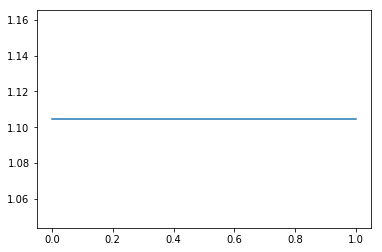

In [140]:
for one in issues:
    net = Net(vocab_size, hidden_size,100)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.1)
    
    
    if(one == '0'):
        continue
    data_withot_one_issue = data_pd[data_pd.Issue != one]
    data_with_the_issue = data_pd[data_pd.Issue == one]
    
    data_list_with = data_withot_one_issue.values
    data_list_without = data_with_the_issue.values
    
    tweets_train = data_list_with[:,0]
    #print(tweets_train[0])
    issue_train = data_list_with[:,3]
    label_train = data_list_with[:,4]
    tweets_test = data_list_without[:,0]
    issue_test = data_list_without[:,3]
    label_test = data_list_without[:,4]
    
    x_tweet_train,y_issue_train, y_label_train = create_data(tweets_train,issue_train,label_train,issues)
    #print(x_tweet_train[0])
    x_tweet_test,y_issue_test, y_label_test = create_data(tweets_test,issue_test,label_test,issues)
    x_tweet_test, y_label_test = Variable(torch.LongTensor(x_tweet_test)), Variable(torch.LongTensor(y_label_test))
    #print(x_tweet_test)
    train_losses = []
    test_losses = []
    
    epoch_losses = []
    for e in range(0,2):
        epoch_loss = 0
        for idx in range(0,int(len(x_tweet_train)/batch_size)+1):
            net.zero_grad()
            batch_x, batch_y = batches_train(x_tweet_train,y_label_train,batch_size,idx)
            batch_x = Variable(torch.LongTensor(batch_x))
            batch_y = Variable(torch.LongTensor(batch_y))
            batch_y = batch_y.reshape(batch_y.shape[0])
            encoder_hidden = Variable(net.H_t0(batch_y.shape[0]))
            output = net(batch_x,encoder_hidden)
            loss = criterion(output[0], batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data[0]
        epoch_loss /= len(x_tweet_train)/batch_size
        epoch_losses.append(epoch_loss)
    
    encoder_hidden_test = Variable(net.H_t0(len(x_tweet_test)))
    predicted_output = net(x_tweet_test,encoder_hidden_test)
    predicted_output = predicted_output.reshape(len(x_tweet_test),3)
    predicted_output = predicted_output.detach().numpy()
    predicted_output = np.argmax(predicted_output,axis = 1)
    predicted_list[one] = predicted_output
    ground_truth[one] = y_label_test
    accuracy = accuracy_score(predicted_output,y_label_test)
    print(accuracy)
    plt.plot(epoch_losses)
    plt.show()
    epoch_loss_all_issues[one] = epoch_losses
    break


In [185]:
#x_tweet_test, y_label_test = Variable(torch.FloatTensor(x_tweet_test)), Variable(torch.LongTensor(y_label_test))
predicted_output = net(x_tweet_test,encoder_hidden_test)
predicted_output = predicted_output.reshape(len(x_tweet_test),3)
predicted_output = predicted_output.detach().numpy()
predicted_output = np.argmax(predicted_output,axis = 1)
predicted_list[one] = predicted_output
ground_truth[one] = y_label_test
accuracy = accuracy_score(predicted_output,y_label_test)
print(accuracy)

0.11757857974388825


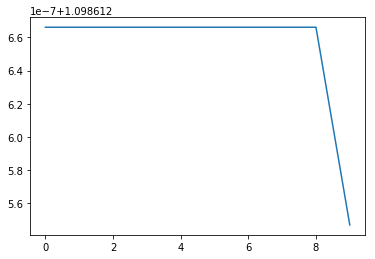

In [174]:
plt.plot(epoch_losses)

In [153]:
pp = predicted_output.reshape(2577,3)
pp = pp.detach().numpy()

In [175]:
x_tweet_test,y_issue_test, y_label_test = create_data_wv(tweets_test,issue_test,label_test,issues)
x_tweet_test = Variable(torch.FloatTensor(x_tweet_test))

/home/bedanta/ml/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [158]:
count = 0
for i in range(len(pred)):
    if(pred[i]==y_label_test[i]):
        count+=1

In [122]:
leng =0
sent = None
for i in tweets_train:
    if(len(i.split())>leng):
        leng = len(i.split())
        sent = i

In [124]:
torch.max(output,dim = 2)[1][0]

tensor([0, 0, 0, 0, 0, 0, 0])

In [141]:
aa = np.load('predicted_list.npy')

In [142]:
aa

array(defaultdict(<class 'list'>, {'RightToPrivacy SC Verdict': array([1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1,
       1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1]), 'reservation': array([0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2,
       0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2]), 'Swacch Bharat': array([0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0,
       0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 0, 2,
       0, 0, 0, 0, 2, 2, 1, 1